In [1]:
!pip install d2l
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

     |████████████████████████████████| 83 kB 1.6 MB/s 


In [2]:
#8.6.1. 定义模型
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
#我们使用张量来初始化隐藏状态，它的形状是（隐藏层数，批量大小，隐藏单元数）。
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [3]:
#通过一个隐藏状态和一个输入，我们就可以用更新后的隐藏状态计算输出。
#需要强调的是，rnn_layer的“输出”（Y）不涉及输出层的计算：它是指每个时间步的隐藏状态，这些隐藏状态可以用作后续输出层的输入。
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [4]:
#与 8.5节 类似，我们为一个完整的循环神经网络模型定义了一个RNNModel类。
#注意， rnn_layer 只包含隐藏的循环层，我们还需要创建一个单独的输出层。
class RNNModel(nn.Module):
    """循环神经网络模型。"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），`num_directions`应该是2，否则应该是1。
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将`Y`的形状改为(`时间步数`*`批量大小`, `隐藏单元数`)。
        # 它的输出形状是 (`时间步数`*`批量大小`, `词表大小`)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` 以张量作为隐藏状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            # `nn.LSTM` 以张量作为隐藏状态
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

In [5]:
#8.6.2. 训练与预测
#在训练模型之前，让我们基于一个具有随机权重的模型进行预测。
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerpfffffffff'

perplexity 1.3, 108084.8 tokens/sec on cuda:0
time travellerit would have allit t rean besp the enent move abl
traveller after the pauserequired for the proper assimilati


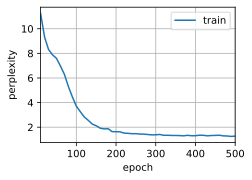

In [6]:
#很明显，这种模型根本不能输出好的结果。接下来，我们使用 8.5节 中定义的超参数调用 train_ch8，并且使用高级API训练模型。
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)